## QBUS3850 Tutorial 6 (ARCH)

To install Kevin Sheppard's 'arch' package:
 - in the Anaconda Prompt: `conda install arch -c bashtage`, or
 - using pip3 in an Administrator cmd prompt: `pip3 install arch`
 
This tutorial uses arch version 4.13.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats as st
from arch import arch_model

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

The ARCH(1) model is defined by
$$
\begin{align}
a_t &= \sigma_t \epsilon_t \\
\sigma_t^2 &= \alpha_0 + \alpha_1 a_{t-1}^2
\end{align}
$$
where $\alpha_0 > 0$ and $\alpha_1 \ge 0$, and $\epsilon_t$ are iid with mean zero and variance 1.
The unconditional mean of $a_t$ is zero because
$$
E(a_t) = \sigma_t E( \epsilon_t ) = 0 .
$$
The unconditional variance of $a_t$ can be computed as
$$
\begin{align}
Var( a_t ) &= E(a_t^2) \\
           &= E( \alpha_0 + \alpha_1 a_{t-1}^2 ) \\
           &= \alpha_0 + \alpha_1 E( a_{t-1}^2 ) \\
           &= \alpha_0 + \alpha_1 Var( a_t )
\end{align}
$$
where the last line follows by stationarity of $a_t$. Therefore 
$$
Var( a_t ) = \frac{ \alpha_0 }{ 1 - \alpha_1 }. 
$$
By a similar but longer calculation,
$$
E( a_t^4 ) = \frac{ 3 \alpha_0^2 ( 1 + \alpha_1 ) }{ ( 1 - \alpha_1 )( 1 - 3\alpha_1^2 ) }.
$$
The unconditional kurtosis of $a_t$ is therefore
$$
\frac{ E( a_t^4 ) }{ Var(a_t)^2 } = 3 \frac{ 1 - \alpha_1^2 }{ 1 - 3\alpha_1^2 } > 3
$$
$a_t$ is therefore leptokurtic (longer-tailed than the normal distribution).

## Generate synthetic data

1.6903085094570331


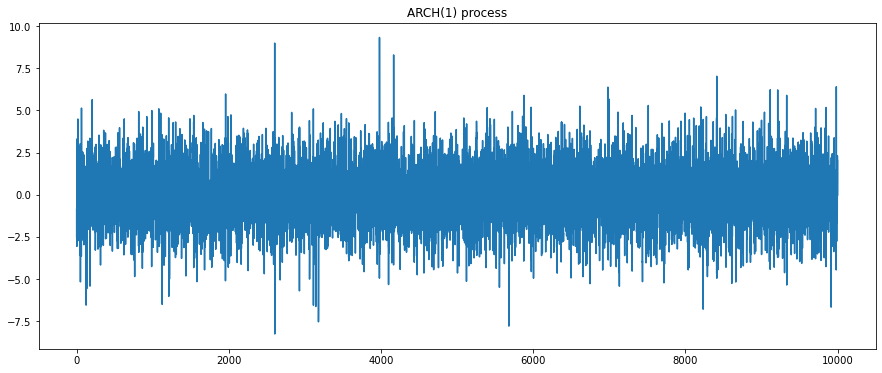

In [3]:
## Setting up the random generator 
np.random.seed( 0xabc123 )

## Length of series
n = 10000

## ARCH(1) coefficients alpha0 and alpha1
a = ( 2.0, 0.3 )
sigma = np.sqrt( a[0] / ( 1 - a[1] ) )
print( sigma )

errors = np.random.normal( 0, 1, n ) 
y = np.zeros( n )
y[0] = np.random.normal( 0, sigma ) 

for i in range( 1, n ):
    y[i] = errors[i] * np.sqrt( a[0] + a[1] * y[i-1] * y[i-1] ) 

plt.title( 'ARCH(1) process' )
plt.plot( y )
plt.show()

In [9]:
## Some relevant summary statistics:

#Summary statistics
def summarise( y ):
    print( 'Mean:     ', np.mean( y ) )
    print( 'Median:   ', np.median( y ) )
    print( 'Stdev:    ', np.std( y ) )
    print( 'Skewness: ', st.skew( y ) )
    print( 'Kurtosis: ', st.kurtosis( y, fisher=False ) ) ## Pearson's definition ( normal == 3.0 )
    print( 'Min:      ', np.min( y ) )
    print( 'Max:      ', np.max( y ) )
    
summarise( y )

Mean:      0.022195229426188054
Median:    0.012187704735240404
Stdev:     1.6954940344379497
Skewness:  -0.002899411012804609
Kurtosis:  3.6114776215486217
Min:       -8.252978287884035
Max:       9.323065156844944


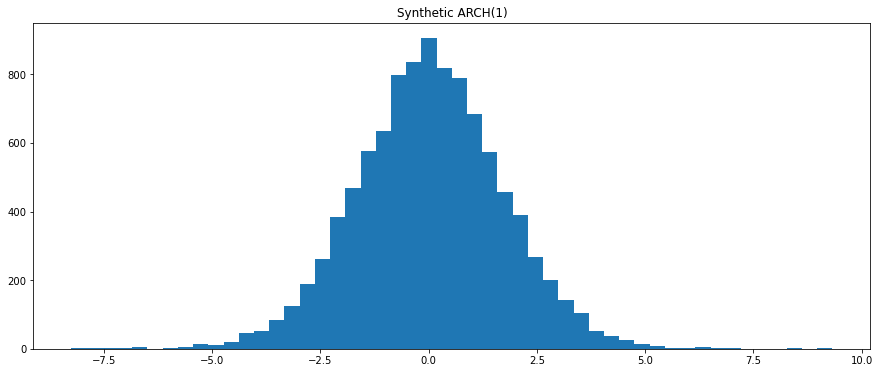

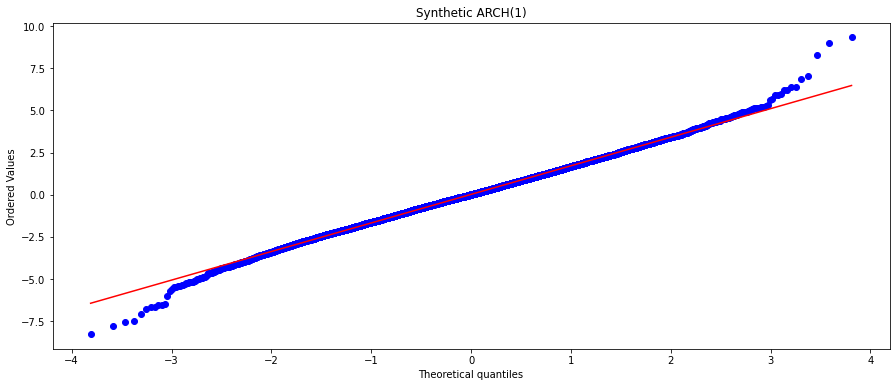

JB test statistic: 155.80771166318416, JB test P-value: 0.0


In [6]:
#Histogram
fig, ax = plt.subplots()
ax.hist( y, bins = 50 )
ax.set_title( 'Synthetic ARCH(1)' )
plt.show()

## qq plot
fig, ax = plt.subplots()
st.probplot( y, plot=ax )
ax.set_title( 'Synthetic ARCH(1)' )
plt.show()

## Jarque-Bera test for Gaussianity
test_stat, p_value = st.jarque_bera( y )
print( 'JB test statistic: {0}, JB test P-value: {1}'.format( test_stat, p_value ) )

## Fit an ARCH(1) model by maximum likelihood

In [7]:
## Estimate ARCH(1) model
fit = arch_model( y, mean='Constant', vol='ARCH', p=1 ).fit( disp=False )
print( fit.summary() )

Iteration:      1,   Func. Count:      5,   Neg. LLF: 19114.644628263828
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19114.566466880708
Iteration:      3,   Func. Count:     21,   Neg. LLF: 19114.449100534373
Iteration:      4,   Func. Count:     29,   Neg. LLF: 19114.44868820499
Iteration:      5,   Func. Count:     34,   Neg. LLF: 19114.44791176305
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:               -19114.4
Distribution:                  Normal   AIC:                           38234.9
Method:            Maximum Likelihood   BIC:                           38256.5
                                        No. Observations:                10000
Date:                Thu, Apr 09 2020   Df Residuals:                     9997
Time:

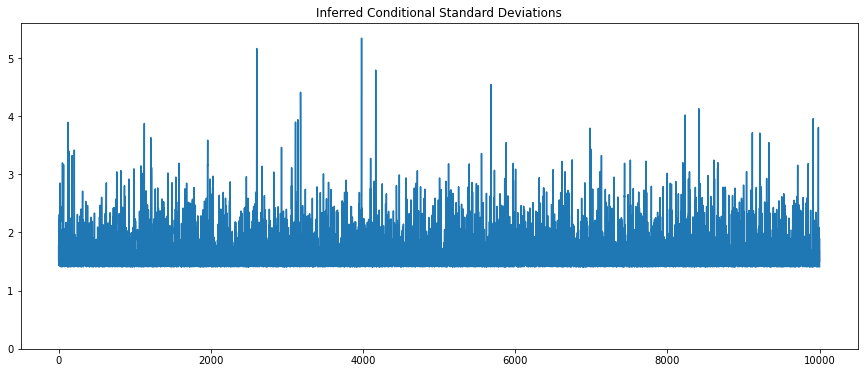

In [8]:
s = fit.conditional_volatility ## Infer the conditional standard deviations
v = s**2                       ## Conditional variance

## Plot the estimated conditional standard deviations against time
figure = plt.figure()
plt.plot( s )
plt.ylim( 0, s.max() * 1.05 )
plt.title( 'Inferred Conditional Standard Deviations' )
#plt.axhline( np.sqrt( a[0] ), color='cyan' )
plt.show()

## Equivalent
#fit.plot()
#print()

### Question: Why is there a clear minimum for inferred conditional standard deviations?

In [9]:
a1 = fit.params[ 'alpha[1]' ] ## coefficient of a(t-1)^2 in conditional vol equation
a0 = fit.params[ 'omega' ]    ## constant term from conditional vol equation

fit_var = a0 / ( 1 - a1 )
sample_var = np.var( y )

fit_kurt = 3 * ( 1 - a1 * a1 ) / ( 1 - 3 * a1 * a1 )
sample_kurt = st.kurtosis( y, fisher=False )

print( 'Model-based unconditional variance estimate: %g' % fit_var )
print( 'Sample variance: %g' % sample_var )

print( 'Model-based unconditional kurtosis estimate: %g' % fit_kurt )
print( 'Sample kurtosis: %g' % sample_kurt )

Model-based unconditional variance estimate: 2.87284
Sample variance: 2.8747
Model-based unconditional kurtosis estimate: 3.78374
Sample kurtosis: 3.61148


## Fit an ARCH(1) model using Engle (1982) LS estimator

In [11]:
a = y - y.mean() #demeaned returns (errors in mean equation)

a2 = a[1:]**2 #demeaned returns squared (y-variable) 
a2_shift = a[:-1]**2 #lagged demeaned returns squared (x-variable)
xmat = np.c_[ np.ones( len(y) - 1 ), a2_shift ] #X matrix for LS regression of ARCH equation

print( np.c_[ a2, xmat ] )

[[6.54718232e+00 1.00000000e+00 7.86843107e-01]
 [2.28167877e-01 1.00000000e+00 6.54718232e+00]
 [9.51033989e+00 1.00000000e+00 2.28167877e-01]
 ...
 [5.24053079e+00 1.00000000e+00 6.98910035e-01]
 [5.72004316e-03 1.00000000e+00 5.24053079e+00]
 [4.00502841e+00 1.00000000e+00 5.72004316e-03]]


In [12]:
#OLS regression of demeaned returns squared vs lags
ls_fit = sm.OLS( endog=a2, exog=xmat ).fit() 
print( ls_fit.summary() )

#Coefficients: constant b[0] and ARCH(1) coefficient b[1]
b = ls_fit.params


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     1056.
Date:                Thu, 09 Apr 2020   Prob (F-statistic):          2.22e-220
Time:                        15:52:44   Log-Likelihood:                -29044.
No. Observations:                9999   AIC:                         5.809e+04
Df Residuals:                    9997   BIC:                         5.811e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9862      0.052     38.224      0.0

In [13]:
## b[0] is the estimate of constant and b[1] is the estimate of the coefficient of a(t-1)^2
ls_var = b[0] / ( 1 - b[1] )
ls_kurt = 3 * ( 1 - b[1]**2 ) / ( 1 - 3*b[1]**2 )

print( 'Model-based unconditional variance estimate from regression: %g' % ls_var) 
print( 'Model-based unconditional kurtosis estimate from regression: %g' % ls_kurt )

Model-based unconditional variance estimate from regression: 2.87505
Model-based unconditional kurtosis estimate from regression: 3.80392


In [14]:
## Re-cap previous results
print( 'Model-based unconditional variance estimate: %g' % fit_var )
print( 'Sample variance: %g' % sample_var )

print( 'Model-based unconditional kurtosis estimate: %g' % fit_kurt )
print( 'Sample kurtosis: %g' % sample_kurt )

Model-based unconditional variance estimate: 2.87284
Sample variance: 2.8747
Model-based unconditional kurtosis estimate: 3.78374
Sample kurtosis: 3.61148
